In [82]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr


sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [83]:
omni_data = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
omni_data

#mean over 1 hr 
omni_data['Timestamp_1min_omni'] = pd.to_datetime(omni_data['Timestamp_1min_omni'])
omni_data = omni_data.set_index('Timestamp_1min_omni')
omni_data = omni_data.resample('5min').mean(numeric_only=True)
#omni_data = omni_data['1999-10-01':'1999-10-01T01:00:00']
omni_data = omni_data.reset_index()
omni_data

,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,F10.7,Kp,tilt_angle
0,1999-10-01 00:00:00,1.84,0.66,485.000000,4.17,178.0,-100.0,79.0,121.900002,23.0,-0.115365
1,1999-10-01 00:05:00,3.35,0.41,481.899994,4.51,178.0,-107.0,71.0,121.900002,23.0,-0.119096
2,1999-10-01 00:10:00,3.26,0.45,480.899994,4.63,178.0,-100.0,78.0,121.900002,23.0,-0.122795
3,1999-10-01 00:15:00,2.70,-1.26,480.000000,4.81,169.0,-89.0,80.0,121.900002,23.0,-0.126461
4,1999-10-01 00:20:00,2.21,-1.06,475.100006,4.71,227.0,-151.0,76.0,121.900002,23.0,-0.130093
...,...,...,...,...,...,...,...,...,...,...,...
8923,1999-10-31 23:35:00,-5.21,-2.83,441.299988,9.98,269.0,-136.0,133.0,158.100006,30.0,-0.294976
8924,1999-10-31 23:40:00,-5.34,-3.97,443.100006,10.59,276.0,-159.0,117.0,158.100006,30.0,-0.298838
8925,1999-10-31 23:45:00,-6.13,-3.75,439.500000,10.79,347.0,-225.0,122.0,158.100006,30.0,-0.302679
8926,1999-10-31 23:50:00,-6.05,-1.36,440.000000,10.92,336.0,-213.0,124.0,158.100006,30.0,-0.306496


In [84]:
def split_to_df(df):

    df = df.copy()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10

    #change data types
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)

    #create grid of lat and lon
    lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))})

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_esn = expanded_df.copy()
    df_esn = df_esn[['dt','lat','lon','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]
    
    return df_esn

df_esn = split_to_df(omni_data)
df_esn

,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,1999-10-01 00:00:00,53.1,1.6,1.84,0.66,485,4.17,-0.115365
1,1999-10-01 00:05:00,53.1,1.6,3.35,0.41,481,4.51,-0.119096
2,1999-10-01 00:10:00,53.1,1.6,3.26,0.45,480,4.63,-0.122795
3,1999-10-01 00:15:00,53.1,1.6,2.70,-1.26,480,4.81,-0.126461
4,1999-10-01 00:20:00,53.1,1.6,2.21,-1.06,475,4.71,-0.130093
...,...,...,...,...,...,...,...,...
21218395,1999-10-31 23:35:00,89.7,357.6,-5.21,-2.83,441,9.98,-0.294976
21218396,1999-10-31 23:40:00,89.7,357.6,-5.34,-3.97,443,10.59,-0.298838
21218397,1999-10-31 23:45:00,89.7,357.6,-6.13,-3.75,439,10.79,-0.302679
21218398,1999-10-31 23:50:00,89.7,357.6,-6.05,-1.36,440,10.92,-0.306496


In [85]:
def load_esn(df):

    df = df.copy()
    df['dt'] = pd.to_datetime(df['dt'])
    df = df.set_index(['dt','lat','lon'])
    ds = df.to_xarray()
    
    ds['BY_GSE'] = ds['BY_GSE'].mean(dim=['lat', 'lon'])
    ds['BZ_GSE'] = ds['BZ_GSE'].mean(dim=['lat', 'lon'])
    ds['flow_speed'] = ds['flow_speed'].mean(dim=['lat', 'lon'])
    ds['proton_density'] = ds['proton_density'].mean(dim=['lat', 'lon'])
    ds['tilt_angle'] = ds['tilt_angle'].mean(dim=['lat', 'lon'])

    def load_model_pca(parameter, id):
        
        with open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_{parameter}_ID{id}.pkl', 'rb') as f:
            model = pickle.load(f)

        
        pca_reload = pickle.load(open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_{parameter}_pca_ID{id}.pkl','rb'))

        return model, pca_reload
    
    pot_model, pot_pca = load_model_pca('potential', 25)
    x_model, x_pca = load_model_pca('x-cond', 5)
    y_model, y_pca = load_model_pca('y-cond', 5)
    xy_model, xy_pca = load_model_pca('xy-cond', 5)

    def make_predictions(ds, model, pca):
        ds = ds.copy()
        prediction_arr = ds.to_array().values.T
        prediction = model.predict(prediction_arr)

        prediction_original = pca.inverse_transform(prediction)
        prediction_original = prediction_original.reshape(-1, 30,80)

        return prediction_original

    prediction_potential = make_predictions(ds, pot_model, pot_pca)
    prediction_x = make_predictions(ds, x_model, x_pca)
    prediction_y = make_predictions(ds, y_model, y_pca)
    prediction_xy = make_predictions(ds, xy_model, xy_pca)

    ds['esn_pot'] = (('dt','lat','lon'), prediction_potential)
    ds['esn_x'] = (('dt','lat','lon'), prediction_x)
    ds['esn_y'] = (('dt','lat','lon'), prediction_y)
    ds['esn_xy'] = (('dt','lat','lon'), prediction_xy)

    #df = ds.to_dataframe()
    #df = df.reset_index()
    #df = df[df['lat'].between(60, 70)]

    return ds

df_esn = load_esn(df_esn)
df_esn

<xarray.Dataset> Size: 679MB
Dimensions:         (dt: 8841, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 170MB 2.312 1.988 ... -20.1 -20.11
    esn_x           (dt, lat, lon) float64 170MB 1.844 1.844 ... 1.637 1.637
    esn_y           (dt, lat, lon) float64 170MB 1.624 1.624 ... 1.637 1.637
    esn_xy          (dt, lat, lon) float64 170MB 1.516 1.516 ... 1.69 1.689

In [86]:
def calculate_E(ds):
    ds = ds.copy()

    def calculate_distance(lat1, lon1, lat2, lon2):
        #return distance between two points in km
        radius = 6371.008

        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        delta_x = dlat * radius #111.32 km per degree
        delta_y = dlon * radius * np.cos(np.radians(lat1)) 
        
        return delta_x, delta_y

    def calculate_delta(mlat, mlt):
        #loop through lat and lon and calculate distance between each point
        delta_x = np.zeros((len(mlat) - 1, len(mlt) - 1))
        delta_y = np.zeros((len(mlat) - 1, len(mlt) - 1))
        for i in range(len(mlat) - 1):
            for j in range(len(mlt) - 1):
                lat1, lat2 = mlat[i], mlat[i + 1]
                lon1, lon2 = mlt[j], mlt[j + 1]

                dx, dy = calculate_distance(lat1, lon1, lat2, lon2)
                delta_x[i, j] = dx
                delta_y[i, j] = dy

        delta_x, delta_y = delta_x , delta_y  #convert to meters

        return delta_x, delta_y
    
    #loop through each timestep and calculate the gradient based on potential, with spacings of dx and dy
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        lat = ds_dt['lat'].values
        lon = ds_dt['lon'].values
        delta_x, delta_y = calculate_delta(lat, lon)
        delta_x, delta_y = delta_x * 1000, delta_y * 1000 #km to m
        potential = ds_dt['esn_pot'].values * 1000  #kV to V

        #add 0 to end of delta_x dim 0
        delta_x = np.append(delta_x, np.ones((1, delta_x.shape[1])), axis=0)
        delta_y = np.append(delta_y, np.ones((delta_y.shape[0], 1)), axis=1)

        grad_x = np.zeros((potential.shape[0], potential.shape[1] - 1), dtype=np.float64)
        grad_y = np.zeros((potential.shape[0] - 1, potential.shape[1]), dtype=np.float64)

        # Calculate lon with dynamic spacing
        for i in range(potential.shape[0]):
            grad_x[i, :] = (potential[i, 1:] - potential[i, :-1]) / delta_x[i, :]

        # Calculate lat with dynamic spacing
        for j in range(potential.shape[1]):
            grad_y[:, j] = (potential[1:, j] - potential[:-1, j]) / delta_y[:, j]

        # Initialize full gradients to match the original array shape
        grad_x_full = np.zeros_like(potential, dtype=np.float64)
        grad_y_full = np.zeros_like(potential, dtype=np.float64)

        grad_x_full[:, :-1] = grad_x
        grad_x_full[:, -1] = (potential[:, -1] - potential[:, -2]) / delta_x[:, -1]  # Simple forward difference

        grad_y_full[:-1, :] = grad_y
        grad_y_full[-1, :] = (potential[-1, :] - potential[-2, :]) / delta_y[-1, :]  #
        
        Ex = -grad_x_full
        Ey = -grad_y_full

        ds_dt['Ex'] = (('lat','lon'), Ex)  
        ds_dt['Ey'] = (('lat','lon'), Ey)

        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    ds = ds.sel(lat=slice(50, 89), lon=slice(0, 357))

    return ds

ds_E = calculate_E(df_esn)
ds_E

<xarray.Dataset> Size: 973MB
Dimensions:         (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon             (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables:
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    esn_x           (dt, lat, lon) float64 162MB 1.844 1.844 ... 1.633 1.631
    esn_y           (dt, lat, lon) float64 162MB 1.624 1.624 ... 1.632 1.63
    esn_xy          (dt, lat, lon) float64 162MB 1.516 1.516 ... 1.712 1.707
    Ex              (dt, lat, lon) float64 162MB 0.002313 0.00239 ... 0.0006911
    Ey              (dt, lat, lon) float64 162MB -0.0003008 ... 0.04316

In [87]:
ds_E['Jhx'] = (-ds_E['esn_xy'] * ds_E['Ex']) * 1000  #east-west *
ds_E['Jhy'] = (ds_E['esn_xy'] * ds_E['Ey']) *  1000 #north-south
ds_E

<xarray.Dataset> Size: 1GB
Dimensions:         (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon             (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables: (12/13)
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    ...              ...
    esn_y           (dt, lat, lon) float64 162MB 1.624 1.624 ... 1.632 1.63
    esn_xy          (dt, lat, lon) float64 162MB 1.516 1.516 ... 1.712 1.707
    Ex              (dt, lat, lon) float64 162MB 0.002313 0.00239 ... 0.0006911
    Ey              (dt, lat, lon) float64 162MB -0.0003008 ... 0.04316
    Jhx             (dt, lat, lon) float64 162MB -3.507 -3.625 ... -1.128 -1.18
    Jhy             (dt, lat, lon) float64 162MB -0.4561 -0.3267 ... 83.39 73.69

In [88]:
#interpolate ds_E over 1 daily
#ds_E = ds_E.resample(dt='1D').mean()
df_E = ds_E.to_dataframe()
df_E = df_E.reset_index()
df_E

,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,esn_pot,esn_x,esn_y,esn_xy,Ex,Ey,Jhx,Jhy
0,1999-10-01 00:00:00,53.100000,1.600000,1.84,0.66,485.0,4.17,-0.115365,2.312141,1.844319,1.624137,1.516323,0.002313,-0.000301,-3.506944,-0.456124
1,1999-10-01 00:00:00,53.100000,6.106329,1.84,0.66,485.0,4.17,-0.115365,1.987573,1.844318,1.624140,1.516316,0.002390,-0.000215,-3.624720,-0.326716
2,1999-10-01 00:00:00,53.100000,10.612658,1.84,0.66,485.0,4.17,-0.115365,1.652104,1.844318,1.624139,1.516316,0.002446,-0.000132,-3.708966,-0.199428
3,1999-10-01 00:00:00,53.100000,15.118987,1.84,0.66,485.0,4.17,-0.115365,1.308837,1.844318,1.624139,1.516317,0.002479,-0.000050,-3.758644,-0.075151
4,1999-10-01 00:00:00,53.100000,19.625316,1.84,0.66,485.0,4.17,-0.115365,0.960973,1.844319,1.624139,1.516317,0.002488,0.000030,-3.772697,0.045137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20254726,1999-10-31 23:55:00,88.437931,335.068354,-5.69,-2.22,443.0,10.68,-0.310287,-19.159150,1.639056,1.638282,1.729493,0.000575,0.064181,-0.994740,111.000222
20254727,1999-10-31 23:55:00,88.437931,339.574684,-5.69,-2.22,443.0,10.68,-0.310287,-19.239866,1.636737,1.635969,1.723206,0.000610,0.059272,-1.050342,102.137890
20254728,1999-10-31 23:55:00,88.437931,344.081013,-5.69,-2.22,443.0,10.68,-0.310287,-19.325404,1.634689,1.633901,1.717492,0.000638,0.054092,-1.095564,92.903170
20254729,1999-10-31 23:55:00,88.437931,348.587342,-5.69,-2.22,443.0,10.68,-0.310287,-19.414922,1.632863,1.632075,1.712300,0.000659,0.048698,-1.127897,83.385327


In [89]:
df_E.groupby('dt')['Jhy'].max().reset_index()

,dt,Jhy
0,1999-10-01 00:00:00,159.421424
1,1999-10-01 00:05:00,128.929526
2,1999-10-01 00:10:00,121.541609
3,1999-10-01 00:15:00,153.398193
4,1999-10-01 00:20:00,167.327414
...,...,...
8836,1999-10-31 23:35:00,239.686894
8837,1999-10-31 23:40:00,224.804671
8838,1999-10-31 23:45:00,238.800940
8839,1999-10-31 23:50:00,208.777689


In [90]:
df_JHy_esn_max = df_E.groupby('dt')['Jhy'].max().reset_index()
df_JHy_esn_max.columns = ['dt','AU']

df_JHy_esn_min = df_E.groupby('dt')['Jhy'].min().reset_index()
df_JHy_esn_min.columns = ['dt','AL']

df_ae = pd.merge(df_JHy_esn_max, df_JHy_esn_min, on='dt')

df_ae['AE'] = df_ae['AU'] - df_ae['AL']
df_ae = df_ae[df_ae['AE'] < 4000]

omni_data['dt'] = pd.to_datetime(omni_data['Timestamp_1min_omni'])
merge_df = pd.merge(df_ae, omni_data, on='dt')
merge_df

,dt,AU,AL,AE,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,F10.7,Kp,tilt_angle
0,1999-10-01 00:00:00,159.421424,-203.924672,363.346096,1999-10-01 00:00:00,1.84,0.66,485.000000,4.17,178.0,-100.0,79.0,121.900002,23.0,-0.115365
1,1999-10-01 00:05:00,128.929526,-176.490918,305.420444,1999-10-01 00:05:00,3.35,0.41,481.899994,4.51,178.0,-107.0,71.0,121.900002,23.0,-0.119096
2,1999-10-01 00:10:00,121.541609,-172.515288,294.056897,1999-10-01 00:10:00,3.26,0.45,480.899994,4.63,178.0,-100.0,78.0,121.900002,23.0,-0.122795
3,1999-10-01 00:15:00,153.398193,-188.516900,341.915093,1999-10-01 00:15:00,2.70,-1.26,480.000000,4.81,169.0,-89.0,80.0,121.900002,23.0,-0.126461
4,1999-10-01 00:20:00,167.327414,-196.737654,364.065068,1999-10-01 00:20:00,2.21,-1.06,475.100006,4.71,227.0,-151.0,76.0,121.900002,23.0,-0.130093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,1999-10-31 23:35:00,239.686894,-184.990152,424.677046,1999-10-31 23:35:00,-5.21,-2.83,441.299988,9.98,269.0,-136.0,133.0,158.100006,30.0,-0.294976
8829,1999-10-31 23:40:00,224.804671,-176.782213,401.586883,1999-10-31 23:40:00,-5.34,-3.97,443.100006,10.59,276.0,-159.0,117.0,158.100006,30.0,-0.298838
8830,1999-10-31 23:45:00,238.800940,-188.255824,427.056763,1999-10-31 23:45:00,-6.13,-3.75,439.500000,10.79,347.0,-225.0,122.0,158.100006,30.0,-0.302679
8831,1999-10-31 23:50:00,208.777689,-156.760386,365.538075,1999-10-31 23:50:00,-6.05,-1.36,440.000000,10.92,336.0,-213.0,124.0,158.100006,30.0,-0.306496


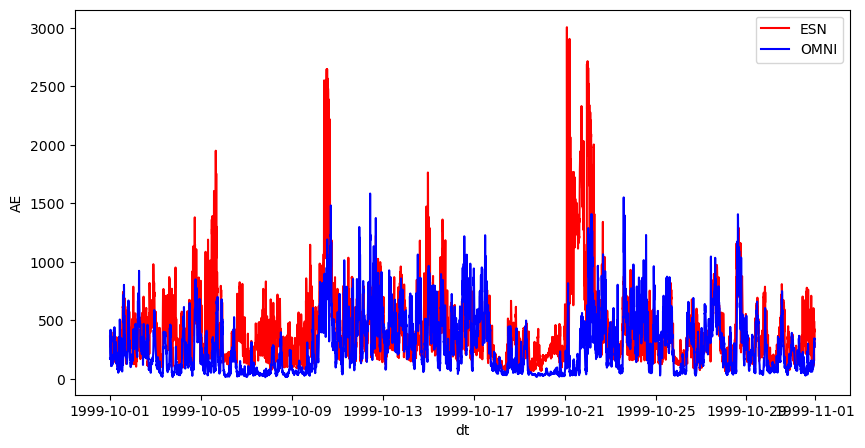

In [91]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=merge_df, x='dt', y='AE', color='red', label='ESN', ax=ax, legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AE_INDEX', color='blue', label='OMNI', ax=ax)
plt.legend()

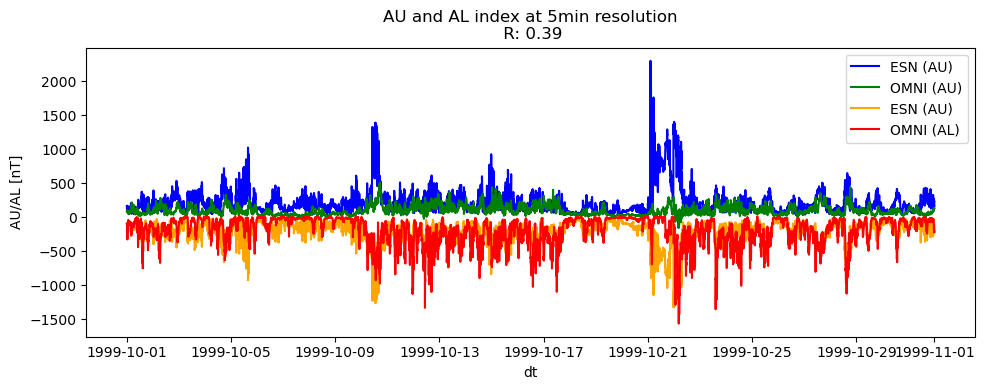

In [133]:
fig, ax = plt.subplots(figsize=(10,4))
R = np.corrcoef(merge_df['AE'], merge_df['AE_INDEX'])[0,1]
sns.lineplot(data=merge_df, x='dt', y='AU', color='blue', label='ESN (AU)', legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AU_INDEX', color='green', label='OMNI (AU)')
sns.lineplot(data=merge_df, x='dt', y='AL', color='orange', label='ESN (AU)', legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AL_INDEX', color='red', label='OMNI (AL)')
plt.ylabel('AU/AL [nT]')
plt.title(f'AU and AL index at 5min resolution\n R: {R:.2f}')
plt.tight_layout()
plt.savefig('ESN_AU-AL_5min.png', dpi=300)

In [114]:
#ds_E['JPx'] = ds_E['esn_x'] * ds_E['Ex']
#ss_E['JPy'] = ds_E['esn_y'] * ds_E['Ey']
ds_E['Qjx'] = ((ds_E['esn_x']) * (ds_E['Ex'])**2) *1e3
ds_E['Qjy'] = ((ds_E['esn_y']) * (ds_E['Ey'])**2) *1e3
ds_E

<xarray.Dataset> Size: 2GB
Dimensions:         (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon             (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables: (12/16)
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    ...              ...
    Ey              (dt, lat, lon) float64 162MB -0.0003008 ... 0.04316
    Jhx             (dt, lat, lon) float64 162MB -3.507 -3.625 ... -1.128 -1.18
    Jhy             (dt, lat, lon) float64 162MB -0.4561 -0.3267 ... 83.39 73.69
    Qjx             (dt, lat, lon) float64 162MB 0.009865 0.01054 ... 0.0007791
    Qjy             (dt, lat, lon) float64 162MB 0.000147 7.54e-05 ... 3.037
    total_power     (dt) float64 71kB 1.31e+06 1.019e+06 ... 1.902e+06 1.498e+06

In [118]:
def total_power(ds):
    ds = ds.copy()
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        #intergrate Qjx over all lat and lon
        Qjx = ds_dt['Qjx'].values 
        Qjy = ds_dt['Qjy'].values

        total_power = np.sum(Qjx) + np.sum(Qjy)
        ds_dt['total_power'] = total_power / 1e6

        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    ds = ds.where(ds['total_power'] > 0)
    return ds        

ds_E = total_power(ds_E)
ds_E

<xarray.Dataset> Size: 2GB
Dimensions:         (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon             (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables: (12/16)
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    ...              ...
    Ey              (dt, lat, lon) float64 162MB -0.0003008 ... 0.04316
    Jhx             (dt, lat, lon) float64 162MB -3.507 -3.625 ... -1.128 -1.18
    Jhy             (dt, lat, lon) float64 162MB -0.4561 -0.3267 ... 83.39 73.69
    Qjx             (dt, lat, lon) float64 162MB 0.009865 0.01054 ... 0.0007791
    Qjy             (dt, lat, lon) float64 162MB 0.000147 7.54e-05 ... 3.037
    total_power     (dt) float64 71kB 1.31e-09 1.019e-09 ... 1.902e-09 1.498e-09

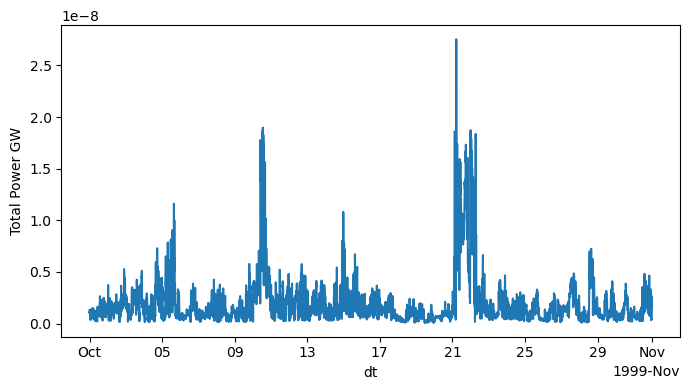

In [124]:
#plot dt and Qjx_tot
plt.figure(figsize=(7,4))
ds_E['total_power'].plot()
plt.ylabel('Total Power GW')
plt.tight_layout()
plt.savefig('ESN_total_power.png', dpi=300)

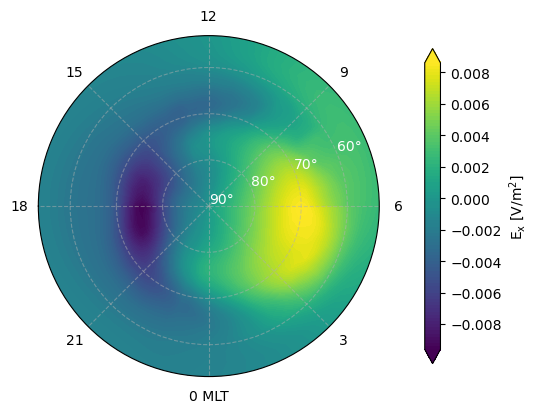

In [112]:
theta = np.linspace(0, 360, 79)
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

Ex = ds_E['Ex'].mean(dim='dt').values
contour = axs.contourf(theta_rad, r, Ex, cmap='viridis', levels=100, extend='both')
Qj_label = r'E$_\mathrm{x}$ [V/m$^2$]'
plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.1,shrink=0.8)
#axs.set_ylim([0, 50])
axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

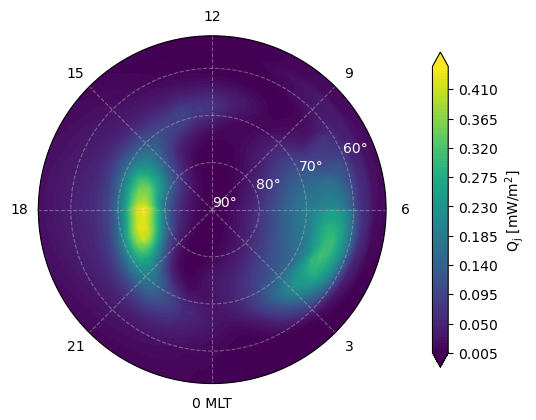

In [122]:
theta = np.linspace(0, 360, 79)
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

Ex = ds_E['Qjx'].mean(dim='dt').values
contour = axs.contourf(theta_rad, r, Ex, cmap='viridis', levels=100, extend='both')
Qj_label = r'Q$_\mathrm{j}$ [mW/m$^2$]'
plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.1,shrink=0.8)
#axs.set_ylim([0, 50])
axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('joule_heating_5min_res.png', dpi=300)